Osnabrück University - Computer Vision (Winter Term 2024/25) - Dr. Ulf Krumnack, Lukas Niehaus, Robin Rawiel

# Exercise Sheet 06: Wavelet Transform

## Introduction

This week's sheet should be solved and handed in before end of **Monday, January 6, 2025**. If you need help (and Google and other resources were not enough), feel free to use the Stud.IP forum. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Eigenvectors and Eigenvalues) [0 Points]

This exercise is intended to revise the notions of eigenvectors and eigenvalues, which will pop up in class soon.  Check if you are comfortable with them. You don't need a deep understanding, but you should have got the basic ideas.  If you have problems to answer these questions offhand, this is a good time to look terms up (again). You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an eigenvector of a matrix/a linear mapping? What are eigenvalues?

YOUR ANSWER HERE

**b)** What is the characteristic polynomial of a matrix? How is it related to eigenvalues? What are algebraic and geometric multiplicity of an eigenvalue?

YOUR ANSWER HERE

**c)** What is the spectrum of a matrix? What does the spectral theorem state?

YOUR ANSWER HERE

**d)** [bonus task]: Numpy/Scipy provide functions to compute eigenvalues. Lookup these functions and apply them to an example.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Assignment 1: Filter design and frequency space (5 points)

**a)** Create and plot the kernels of box filter and binomial filter in frequency space. Vary the kernel size. What do you observe?

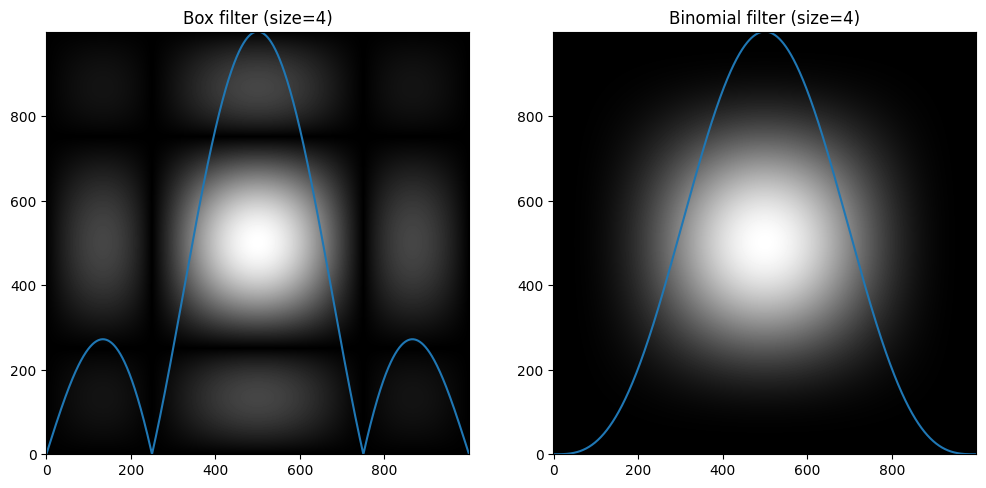

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

kernel_size = 4 # vary this
image_size = 1000

# Compute the Box filter (simple average filter)
box_kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)

# Compute the Binomial filter (1D binomial filter applied in both directions)
binomial_1d = np.array([binom(kernel_size - 1, i) for i in range(kernel_size)])
binomial_kernel = np.outer(binomial_1d, binomial_1d)  # Outer product to create 2D kernel
binomial_kernel /= np.sum(binomial_kernel)  # Normalize the kernel to ensure the sum is 1

# Compute the frequency space representation using FFT
box_frequencies = np.fft.fftshift(np.fft.fft2(box_kernel, s=(image_size, image_size)))
binomial_frequencies = np.fft.fftshift(np.fft.fft2(binomial_kernel, s=(image_size, image_size)))

# plot kernel in frequency space
plt.figure(figsize=(12,6))
plt.gray()
plt.subplot(1,2,1)
plt.title(f"Box filter (size={kernel_size})")
plt.imshow(np.abs(box_frequencies))
plt.plot(np.arange(image_size), np.abs(box_frequencies)[image_size//2]*image_size)
plt.ylim(0, image_size-1)
plt.subplot(1,2,2)
plt.title(f"Binomial filter (size={kernel_size})")
plt.imshow(np.abs(binomial_frequencies))
plt.plot(np.arange(image_size), np.abs(binomial_frequencies)[image_size//2]*image_size)
plt.ylim(0, image_size-1)
plt.show()

As the kernel size increases:

- Box Filter: The frequency space becomes more concentrated around low frequencies, with a smoother and broader central peak.
- Binomial Filter: The filter becomes more Gaussian-like, with stronger low-frequency emphasis and sharper suppression of high frequencies.



**b)** Implement a low pass filter and apply it to the given image with different cut off frequencies $F_{\max}$. What do you observe? Explain that observation and discuss how to improve the result.

Hint: The low pass filter is shown in CV-06 slides 45. 

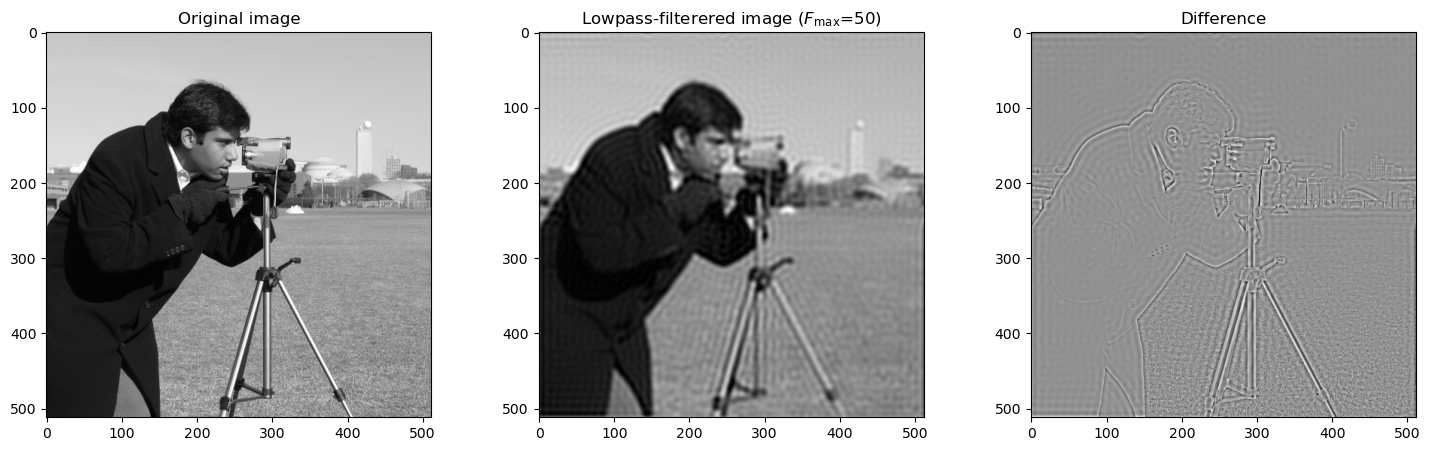

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

f_max = 50
image = imageio.imread('imageio:camera.png')

def low_pass_filter(image, f_max):
    # Step 1: Convert image to frequency space (FFT)
    image_freq = np.fft.fft2(image)
    image_freq_shifted = np.fft.fftshift(image_freq)  # Center the low frequencies

    # Step 2: Create a low-pass filter mask
    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols))
    
    # Create a mask where values within the cutoff frequency are kept
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - center_row)**2 + (j - center_col)**2) <= f_max:
                mask[i, j] = 1
    
    # Step 3: Apply the low-pass filter by element-wise multiplication
    filtered_freq = image_freq_shifted * mask

    # Step 4: Inverse FFT to get the filtered image back in spatial domain
    filtered_image_freq = np.fft.ifftshift(filtered_freq)  # Reverse the shift
    filtered_image = np.abs(np.fft.ifft2(filtered_image_freq))  # Apply inverse FFT

    return filtered_image

filtered_image = low_pass_filter(image, f_max=f_max)

# plot kernel in frequency space
plt.figure(figsize=(18,5))
plt.gray()
plt.subplot(1,3,1); plt.title(f"Original image")
plt.imshow(image) 
plt.subplot(1,3,2); plt.title(f"Lowpass-filterered image ($F_\\max$={f_max})")
plt.imshow(filtered_image)
plt.subplot(1,3,3); plt.title(f"Difference")
plt.imshow(filtered_image-image)
resimg=filtered_image-image
plt.show()

- **Low Cutoff Frequency**: For smaller values of $F_{\max}$, more high-frequency components (such as fine details and noise) are removed, resulting in a blurrier image.
  
- **Higher Cutoff Frequency**: For larger $F_{\max}$, more of the high-frequency content is retained, so the image remains sharper.

- **Impact of Low-Pass Filtering**: The filtered image shows less noise and fine details compared to the original, as the high-frequency components (which often represent noise or small details) are filtered out.

To improve the result, you could use a more sophisticated low-pass filter, such as a Gaussian filter, which has a smoother transition between the frequencies kept and removed, rather than using a hard threshold at $F_{\max}$.


**c)** What is a good kernel size for a Gaussian filter? Justify your answer.

A good kernel size for a Gaussian filter is typically $6\sigma$, where $\sigma$ is the standard deviation. This size captures most of the significant values of the Gaussian function. A kernel smaller than $3\sigma$ may under-smooth, while one larger than $10\sigma$ can lead to excessive blurring and increased computational cost.


## Assignment 2: Discrete Cosine Transform (5 points)

**a)** Read up about the DCT and IDCT functions and check out the scipy implementation.

In [3]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pylab as plt
from scipy.fftpack import dct, idct

In [4]:
def dct_2d_sp(array, type_=2):
    return dct(dct(array, axis=0, type=type_), axis=1, type=type_)

def idct_2d_sp(array, type_=2):
    return idct(idct(array, axis=0, type=type_), axis=1, type=type_)


img = iio.imread("imageio:camera.png")
img_transformed = dct_2d_sp(img)
img_orig = idct_2d_sp(img_transformed)

plt.subplot(131); plt.imshow(img); plt.axis('off'); plt.title('Original Image')
plt.subplot(132); plt.imshow(img_transformed); plt.axis('off'); plt.title('Transformed Image')
plt.subplot(133); plt.imshow(img_orig); plt.axis('off'); plt.title('Restored Image')

Text(0.5, 1.0, 'Restored Image')

**b)** Implement the DCT-II function given by the formula: $C_k = 2 \sum_{n=0}^{N-1} f_n \cos\left(\frac{\pi k(2n+1)}{2N} \right)$

True


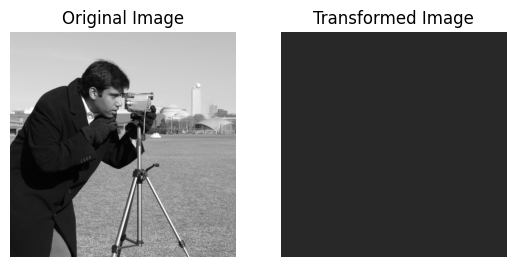

In [6]:
# 1D DCT-II implementation
def my_dct2_1d(f, axis=0):
    N = f.shape[axis]
    C = np.zeros_like(f, dtype=np.float64)
    for k in range(N):
        sum_ = 0
        for n in range(N):
            sum_ += f[tuple(slice(None) if i != axis else n for i in range(f.ndim))] * \
                    np.cos(np.pi * k * (2 * n + 1) / (2 * N))
        C[tuple(slice(None) if i != axis else k for i in range(f.ndim))] = 2 * sum_
    return C

def my_dct2_2d(f):
    # Apply 1D DCT along rows (axis=0)
    f_row_dct = my_dct2_1d(f, axis=0)
    # Apply 1D DCT along columns (axis=1)
    return my_dct2_1d(f_row_dct, axis=1)


img = iio.imread("imageio:camera.png")
img_transformed = my_dct2_2d(img)

plt.subplot(121); plt.imshow(img); plt.axis('off'); plt.title('Original Image')
plt.subplot(122); plt.imshow(img_transformed); plt.axis('off'); plt.title('Transformed Image')

print((img_transformed.round() == dct_2d_sp(img, type_=2).round()).all())
plt.show()

**c)** Implement the DCT-III function given by the formula: $C_k = f_0 + 2 \sum_{n=1}^{N-1} f_n \cos\left(\frac{\pi(2k+1)n}{2N}\right)$

True


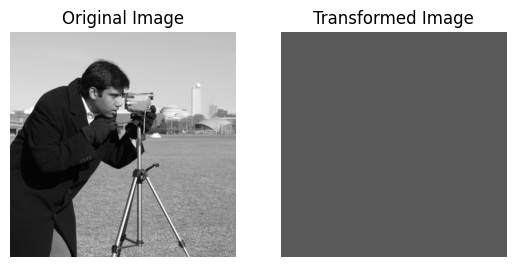

In [7]:
# Function to apply DCT-III to 1D data along the specified axis
def my_dct3_1d(f, axis=0):
    N = f.shape[axis]  # Get the size of the array along the specified axis
    C = np.zeros_like(f, dtype=np.float64)  # Initialize an array to store the result with the same shape as f
    
    if axis == 0:
        # Along the rows (axis 0)
        for k in range(N):  # Loop through each frequency component (k)
            # Compute the cosine terms 
            cos_term = np.cos(np.pi * (2 * k + 1) * np.arange(1, N) / (2 * N))
            # Compute for the k-th row (this is the summation part)
            C[k, :] = f[0, :] + 2 * np.sum(f[1:, :] * cos_term[:, np.newaxis], axis=0)
    elif axis == 1:
        # Apply along the columns (axis 1)
        for k in range(N):  # Loop through each frequency component (k)
            # Compute the cosine terms
            cos_term = np.cos(np.pi * (2 * k + 1) * np.arange(1, N) / (2 * N))
            # Compute for the k-th column (this is the summation part)
            C[:, k] = f[:, 0] + 2 * np.sum(f[:, 1:] * cos_term[np.newaxis, :], axis=1)
    
    return C  

# Function to apply DCT-III to a 2D array by applying it to rows and columns
def my_dct3_2d(f):
    # Apply DCT-III along the rows (axis 0)
    f = my_dct3_1d(f, axis=0)  
    # Apply DCT-III along the columns (axis 1)
    return my_dct3_1d(f, axis=1)


img = iio.imread("imageio:camera.png")
img_transformed = my_dct3_2d(img)

plt.subplot(121); plt.imshow(img); plt.axis('off'); plt.title('Original Image')
plt.subplot(122); plt.imshow(img_transformed); plt.axis('off'); plt.title('Transformed Image')

print((img_transformed.round() == dct_2d_sp(img, type_=3).round()).all())
plt.show()

**d)** What relationship between the DCT-II, DCT-III, IDCT-II and IDCT-III can be observed? Demonstrate your findings. (If you did not solve exercises b and c, you may use provided `dct_2d_sp` function).

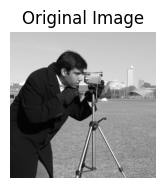

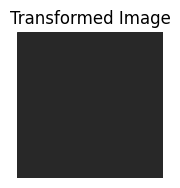

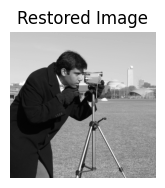

False
True


In [8]:
normalize = lambda x: x.astype(np.float64)/np.max(x)

img = iio.imread("imageio:camera.png")
img = normalize(img)

# Load and normalize the image
img = iio.imread("imageio:camera.png")
img = normalize(img)

# Perform DCT-II transformation (type=2)
dct_img_2 = dct(dct(img, axis=0, type=2), axis=1, type=2)

# Perform DCT-III transformation (type=3)
dct_img_3 = dct(dct(img, axis=0, type=3), axis=1, type=3)

# Apply IDCT-II to the DCT-II transformed image
img_restored_2 = idct(idct(dct_img_2, axis=0, type=2), axis=1, type=2)

# Apply IDCT-III to the DCT-III transformed image
img_restored_3 = idct(idct(dct_img_3, axis=0, type=3), axis=1, type=3)

# Store original image for comparison after transformations
img_orig = normalize(img)  # Normalize original image


plt.subplot(131); plt.imshow(img); plt.axis('off'); plt.title('Original Image');plt.show()
plt.subplot(132); plt.imshow(dct_img_2); plt.axis('off'); plt.title('Transformed Image');plt.show()
plt.subplot(133); plt.imshow(img_restored_2); plt.axis('off'); plt.title('Restored Image');plt.show()

# Print if the original image is the same as the restored one
print((img.round() == img_restored_2.round()).all())
print((img.round() == img_orig.round()).all())

## Assignment 3: Wavelet Transform (5 points)

**a)** Write a function that transforms a mother wavelet into a wavelet function.

In [9]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

def wavelet(mother_wavelet, s=1, d=0):
    # Transform the mother wavelet using scale 's' and shift 'd'
    func = lambda x: (1/np.sqrt(s)) * mother_wavelet((x - d) / s)  # Apply the scaling and translation
    return func


**b)** Write a function for the Gabor mother wavelet.

In [10]:
def gabor_mother_wavelet(x, sigma=1, k=1, s=1, d=0):
    # Gaussian envelope with scaling (s) and translation (d)
    gaussian = np.exp(-0.5 * ((x - d) ** 2) / (sigma ** 2 * s ** 2))
    
    # Complex Gabor wavelet: Gaussian envelope times complex oscillation (cos + i*sin)
    wavelet = gaussian * np.exp(1j * k * (x - d))  # Complex exponential
    
    return wavelet


**c)** Plot the real and imaginary part of the gabor wavelet. Use the Interval $\left[ -10, 10 \right]$ and $\sigma=3$.

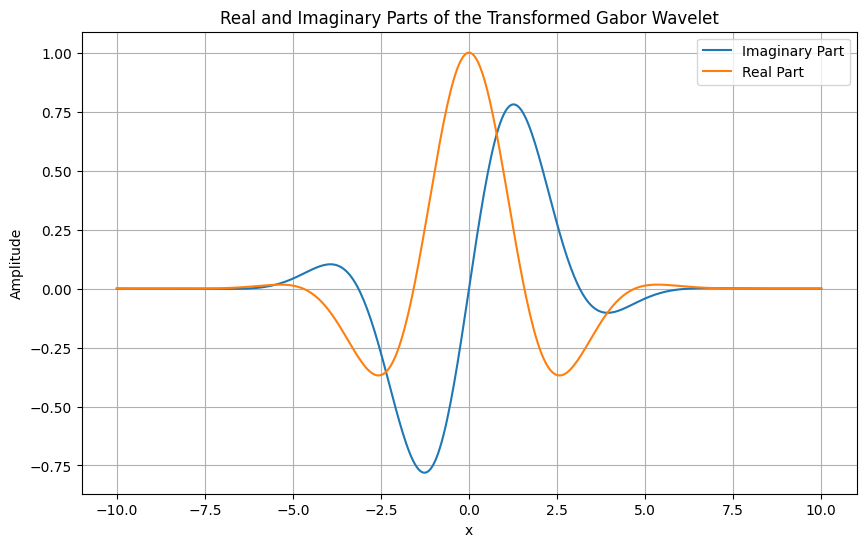

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gabor mother wavelet (complex-valued) with scaling (s) and translation (d)
def gabor_mother_wavelet_complex(x, sigma=3, k=1, s=1, d=0):
    # Gaussian envelope with scaling (s) and translation (d)
    gaussian = np.exp(-2 * (x - d)**2 / (2 * sigma**2 * s**2))
    
    # Complex oscillatory part (exp(-ik(x - d)))
    real_part = gaussian * np.cos(k * (x - d))
    imaginary_part = gaussian * np.sin(k * (x - d))
    
    return real_part, imaginary_part

# Define the range for x
x = np.linspace(-10, 10, 400)

# Set the parameters
sigma = 2
k = 1  # Frequency of the oscillation
s = 1  # Scaling factor
d = 0 # Translation factor

# Get the complex Gabor wavelet
wavelet = gabor_mother_wavelet(x, sigma, k, s, d)

# Plot the real and imaginary parts
plt.figure(figsize=(10, 6))
plt.plot(x, wavelet.imag, label='Imaginary Part')
plt.plot(x, wavelet.real, label='Real Part')
plt.legend()
plt.title("Real and Imaginary Parts of the Transformed Gabor Wavelet")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


**d)** Plot the real and imaginary part of the gabor wavelet in 3d. Use the Interval $\left[ -10, 10 \right]$ and $\sigma=3$.

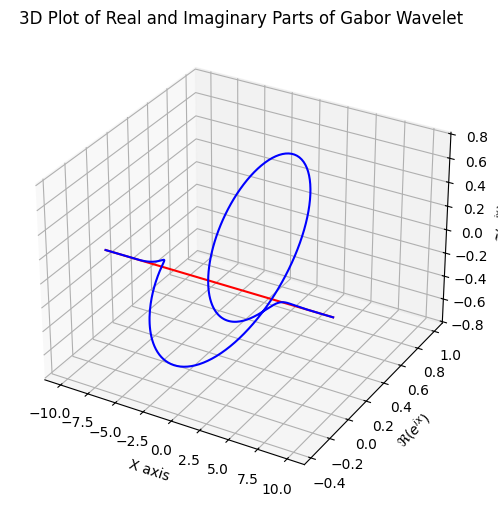

In [12]:
# Create the 3D plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection="3d")

# Add a red line from the start to the end of the wavelet
ax.plot3D([x[0], x[-1]], [wavelet.real[0], wavelet.real[-1]], [wavelet.imag[0], wavelet.imag[-1]], color='r')

# Plot the real and imaginary parts
ax.plot3D(x, wavelet.real, wavelet.imag, label="Gabor Wavelet", color='b')

# Labels and title
ax.set_xlabel("X axis")
ax.set_ylabel("$\\Re(e^{ix})$")
ax.set_zlabel("$\\Im(e^{ix})$")
ax.set_title("3D Plot of Real and Imaginary Parts of Gabor Wavelet")
plt.show()

**e)** Implement the Haar Basis Wavelet and the Haar Scale Wavelet.

### Haar Basis Wavelet 

$$
\psi_{\text{Haar}}(x) =
\begin{cases}
\frac{1}{\sqrt{2}} & \text{for } 0 \leq x < 1 \\
-\frac{1}{\sqrt{2}} & \text{for } 1 \leq x < 2 \\
0 & \text{otherwise}
\end{cases}
$$

### Haar Scaling Wavelet

$$
\phi_{\text{Haar}}(x) =
\begin{cases}
\frac{1}{\sqrt{2}} & \text{for } 0 \leq x < 2 \\
0 & \text{otherwise}
\end{cases}
$$

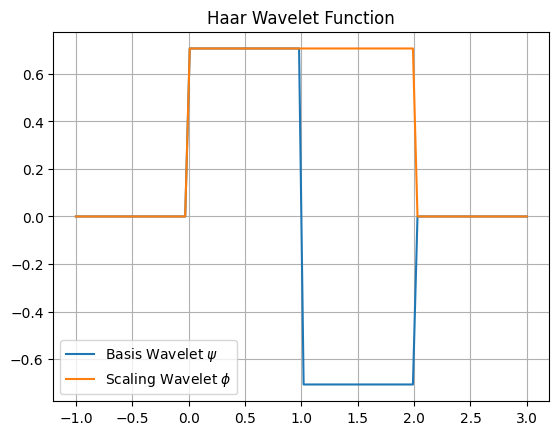

In [13]:
# Define the Haar Basis Wavelet ψHaar(x) according to the definition from lecture
def haar_basis_wavelet(x):
    ret = np.zeros(x.shape)
    for i in range(len(x)):
        if 0 <= x[i] < 1:
            ret[i] = 1/np.sqrt(2)
        elif 1 <= x[i] < 2:
            ret[i] = -1/np.sqrt(2)
        else:
            ret[i] = 0
    return ret

# Define the Haar Scaling Wavelet ϕHaar(x)
def haar_scale_wavelet(x):
    ret = np.zeros(x.shape)
    for i in range(len(x)):
        if 0 <= x[i] < 2:
            ret[i] = 1/np.sqrt(2)
        else:
            ret[i] = 0
    return ret

x = np.linspace(-1, 3, 100)
plt.grid()
plt.plot(x, haar_basis_wavelet(x), label="Basis Wavelet $\\psi$")
plt.plot(x, haar_scale_wavelet(x), label="Scaling Wavelet $\\phi$")
plt.legend()
plt.title("Haar Wavelet Function")
plt.show()